# Introduction
This notebook compares Prophet's and a Linear Regression (Baseline model) models performance to predict total daily energy demand in Saskatchewan. 
Each model is trained and tested using a train-test split and cross-validation. The models’ performances are evaluated using metrics, such as Mean Squared Error (MSE), Mean Absolute Error (MAE), Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), Median Absolute Percentage Error (MdAPE), and R-squared and the results are stored for each fold in the cross-validation. Finally, the performance of all models are compared, conclusions are drawn based on the evaluation metrics, and potential improvements for future work are considered.

# Load Data
Forecasting daily natural gas consumption accurately is difficult because it is affected by various factors. The dataset is the historical daily natural gas demand in energy unit (TJ/d) and the weather data in Saskatchewan from November 1, 2013 to October 31, 2023. This dataset has be preprocessed and explored in the "cleaning_EDA.ipynb" notebook and is fit for model development. 

In [2]:
# Importing the necessary libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importing libraries for modules
from prophet import Prophet
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pickle
import warnings 
warnings.filterwarnings('ignore')

In [3]:
# Import the merged dataset (Natural Gas demand and Weather factors)
merged_df = pd.read_csv('../data/merged_data.csv')
merged_df.head()

,DATE,NG_DEMAND,LOWEST_REL_HUMIDITY,HIGHEST_REL_HUMIDITY,HEATING_DEGREE_DAYS,COOLING_DEGREE_DAYS,TOTAL_PRECIPITATION,LOWEST_TEMPERATURE,AVG_TEMPERATURE,HIGHEST_TEMPERATURE,DIRECTION_MAX_GUST,SPEED_MAX_GUST
0,2013-11-01,617,44.400000,80.333333,14.833333,0.0,0.140000,-2.933333,3.166667,9.206667,28.066667,40.600000
1,2013-11-02,630,34.133333,73.066667,16.293333,0.0,0.226667,-5.866667,1.706667,9.266667,8.400000,25.400000
2,2013-11-03,688,60.133333,81.600000,16.726667,0.0,5.806667,-2.166667,1.273333,4.706667,24.400000,55.000000
3,2013-11-04,815,66.466667,79.133333,23.540000,0.0,0.900000,-9.106667,-5.540000,-1.906667,31.466667,56.933333
4,2013-11-05,789,53.000000,71.666667,27.820000,0.0,0.040000,-14.966667,-9.820000,-4.633333,15.800000,21.600000


# Data Preparation for Modelling 

For this step, we are preparing the series for the Train-test Split method.

- Train-test Split method: This method involves splitting the dataset into a training set and a testing set. The model is trained on the training set and then tested on the testing set to evaluate its performance.s

In [4]:
# Split the data into learning set from 2013-11-01 to 2022-04-31, and using 2022-05-01 to 2023-10-31 as testing set
learning_data_df = merged_df[merged_df['DATE'] < '2022-05-01'] # train/validation set
testing_data_df = merged_df[merged_df['DATE'] >= '2022-05-01'] # testing set

# Print the shape of the train-test split
print(learning_data_df.shape)
print(testing_data_df.shape)

(3103, 12)
(549, 12)


# Baseline Model
- In every modeling process, there needs to be a baseline model whose results can be used to assess our primary ones.
- In our case, we chose to use a Linear Regression model because of its simplicity and efficiency.

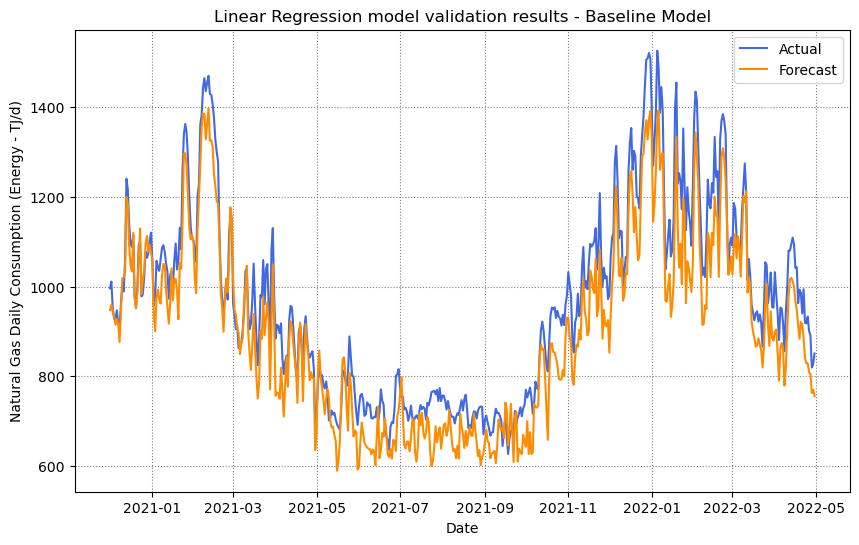

Mean Squared Error: 6656.06
Mean Absolute Error: 70.18
Root Mean Squared Error: 81.58
R-squared: 0.85
Mean Absolute Percentage Error: 7.33%
Median Absolute Percentage Error: 7.05%


In [5]:
# Split the learning dataset to training and validation sets
learning_df = learning_data_df.copy()
training_df = learning_df[learning_df['DATE'] < '2020-12-01']
validation_df = learning_df[learning_df['DATE'] >= '2020-12-01']

# Function to calculate MAPE and MdAPE
def calculate_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    mdape = np.median(np.abs((y_true - y_pred) / y_true)) * 100
    return mape, mdape

# Use the train_df for training
X_train = training_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y_train = training_df['NG_DEMAND']

# Use the validation_df for testing
X_validate = validation_df.drop(['DATE', 'NG_DEMAND'], axis=1)
y_validate = validation_df['NG_DEMAND']

# Create a Linear Regression object
lr = LinearRegression()

# Train the model
lr.fit(X_train, y_train)

# Make predictions on the test set
predictions = lr.predict(X_validate)

# Calculate the mean squared error of the predictions
mse_bm = mean_squared_error(y_validate, predictions)
mae_bm = mean_absolute_error(y_validate, predictions)
rmse_bm = np.sqrt(mse_bm)
r2_bm = r2_score(y_validate, predictions)
mape_bm, mdape_bm = calculate_percentage_error(y_validate, predictions)

# Convert the Date to datetime
validation_df['DATE'] = pd.to_datetime(validation_df['DATE'])

# Plot actual vs. forecast values
plt.figure(figsize=(10, 6))
plt.plot(validation_df['DATE'], y_validate, label='Actual', color='royalblue')
plt.plot(validation_df['DATE'], predictions, label='Forecast', color='darkorange')
plt.title('Linear Regression model validation results - Baseline Model')
plt.xlabel('Date')
plt.ylabel('Natural Gas Daily Consumption (Energy - TJ/d)')
plt.legend()
plt.grid(linestyle=":", color='grey')
plt.show()

print(f'Mean Squared Error: {mse_bm:.2f}')
print(f'Mean Absolute Error: {mae_bm:.2f}')
print(f'Root Mean Squared Error: {rmse_bm:.2f}')
print(f'R-squared: {r2_bm:.2f}')
print(f'Mean Absolute Percentage Error: {mape_bm:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_bm:.2f}%')



# Prophet Models
Prophet uses a combination of regression models and Bayesian inference to model time series data. it allows the flexibility to model complicated time series features by fitting trends and multiple seasonalities to incorporate yearly, monthly, weekly and daily pattens along with holiday effects.

FBProphet also allows for the inclusion of additional regressors in the model. Regressors are external variables that may influence the time series, such as holidays, weather patterns, or marketing campaigns. Including regressors in the model can improve the accuracy of the forecasts by capturing the effects of these external variables on the time series.

The model development include a base Prophet model using the train-test split and cross-validation method. Then the better performed model is further turnd to refined the model performance.

## 2. Cross-validation on Time Series
- The method that can be used for cross-validating the time-series model is cross-validation on a rolling basis. Start with a small subset of data for training purpose, forecast for the later data points and then checking the accuracy for the forecasted data points. The same forecasted data points are then included as part of the next training dataset and subsequent data points are forecasted.
- The dataset contains 10 years (3651 days) of daily sales data, which has be splited into training data (2952 days) and test data (700 days), see previous cells.
- TimeSeriesSplit is a variation of k-fold which returns first  folds as train set and th (k+1)
 th fold as test set. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before the
- For this project, we carried out cross-validation on the training dataset (2952 days), such that part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set (700 days).
- This means that the e initial training period is set to the firs787 dayss). Cross-validation is performed ever14756 das), and each cross-validation step generates forecasts for the nex14756 dss). The Prophet model is trained for each fold, metrics are evaluated and stored for each fold, and average metrics are calculated and printed.

### 2.1 Univariate Model

01:34:42 - cmdstanpy - INFO - Chain [1] start processing
01:34:46 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

01:35:44 - cmdstanpy - INFO - Chain [1] start processing
01:35:45 - cmdstanpy - INFO - Chain [1] done processing
01:36:44 - cmdstanpy - INFO - Chain [1] start processing
01:36:44 - cmdstanpy - INFO - Chain [1] done processing
01:37:43 - cmdstanpy - INFO - Chain [1] start processing
01:37:44 - cmdstanpy - INFO - Chain [1] done processing


     horizon           mse        rmse         mae      mape     mdape  \
0    37 days   8281.895235   91.004919   74.298907  0.102502  0.094324   
1    38 days   8286.364601   91.029471   74.374164  0.102748  0.091620   
2    39 days   8158.869226   90.326459   73.778029  0.102252  0.091620   
3    40 days   7991.204267   89.393536   72.937590  0.101453  0.091226   
4    41 days   7817.378980   88.415943   71.646784  0.099862  0.090084   
..       ...           ...         ...         ...       ...       ...   
324 361 days  17125.781241  130.865508  105.514787  0.112387  0.104789   
325 362 days  17788.840017  133.374810  108.826023  0.116821  0.113103   
326 363 days  17987.664599  134.118099  109.877977  0.118740  0.117495   
327 364 days  18372.589724  135.545526  112.079185  0.122289  0.121361   
328 365 days  18722.314099  136.829507  113.526604  0.125476  0.124722   

        smape  coverage  
0    0.108279  0.899083  
1    0.108642  0.899083  
2    0.108165  0.905199  
3    0.

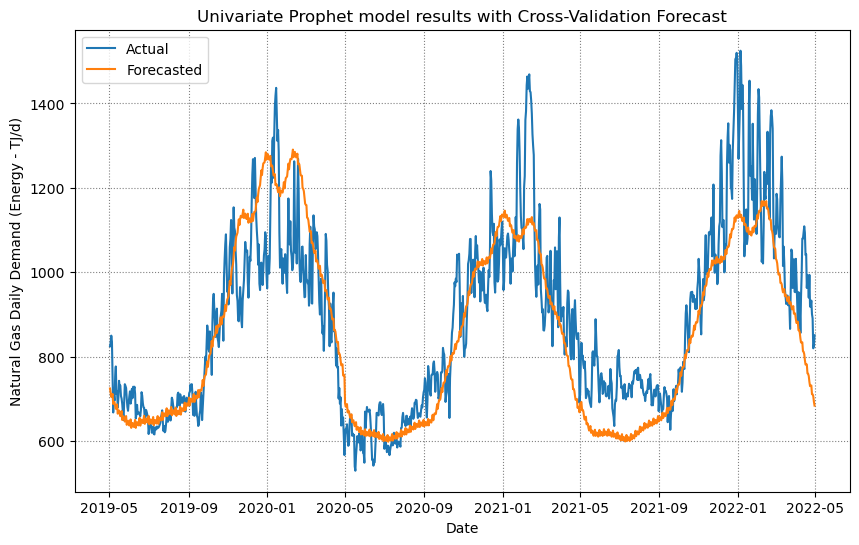

Validation Mean Absolute Error: 87.80
Validation Mean Squared Error: 13639.39
Validation Root Mean Squared Error: 116.79
Validation R-squared: 0.70
Validation Mean Absolute Percentage Error: 9.38%
Validation Median Absolute Percentage Error: 7.86%


In [6]:
# Prepare the training dataset for Prophet by renaming columns to 'ds' (Date) and 'y' (value)
train_val_df1 = learning_data_df.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})

# Add a new column 'y_lagged' that contains 'y' shifted by 1 day
train_val_df1['y_lagged'] = train_val_df1['y'].shift(1)

# Define a wrapper class for the Prophet model
class ProphetWrapper(BaseEstimator, RegressorMixin):
    # Initializing the class with default parameters
    def __init__(self, interval_width=0.9, yearly_seasonality=True, seasonality_mode='multiplicative'):
        self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.model = None

    # Defining the fit method to train the model
    def fit(self, X, y=None):
        # Creating a Prophet model with the given parameters
        self.model = Prophet(interval_width=self.interval_width, yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode)

        # Fitting the model to the data
        self.model.fit(X)

        return self

    # Defining the predict method to generate predictions
    def predict(self, X):
        return self.model.predict(X)

# Define the initial training size, the period, and the horizon
initial, period, horizon = 1644, 365, 365

# Instantiate and fit the model using 'y_lagged' as the target variable
model = ProphetWrapper()
model.fit(train_val_df1)

# Perform cross-validation on the training/validation set
df_cv = cross_validation(model.model, initial=f'{initial} days', period=f'{period} days', horizon=f'{horizon} days')

# Calculate performance metrics for the cross-validation
df_metrics = performance_metrics(df_cv)
print(df_metrics)

# Calculate MAE, MSE, RMSE, and R-squared
mae_cv = mean_absolute_error(df_cv['y'], df_cv['yhat'])
mse_cv = mean_squared_error(df_cv['y'], df_cv['yhat'])
rmse_cv = np.sqrt(mse_cv)
r2_cv = r2_score(df_cv['y'], df_cv['yhat'])
mape_cv = np.mean(np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])) * 100
mdape_cv = np.median(np.abs((df_cv['y'] - df_cv['yhat']) / df_cv['y'])) * 100

# Plotting actuals and forecasted values for the cross-validation
plt.figure(figsize=(10, 6))
plt.plot(df_cv['ds'], df_cv['y'], label='Actual')
plt.plot(df_cv['ds'], df_cv['yhat'], label='Forecasted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Natural Gas Daily Demand (Energy - TJ/d)')
plt.grid(linestyle=":", color='grey')
plt.title('Univariate Prophet model results with Cross-Validation Forecast')
plt.show()

# Print the model performance metrics 
print(f'Validation Mean Absolute Error: {mae_cv:.2f}')
print(f'Validation Mean Squared Error: {mse_cv:.2f}')
print(f'Validation Root Mean Squared Error: {rmse_cv:.2f}')
print(f'Validation R-squared: {r2_cv:.2f}')
print(f'Validation Mean Absolute Percentage Error: {mape_cv:.2f}%')
print(f'Validation Median Absolute Percentage Error: {mdape_cv:.2f}%')



### 2.2 Multivariate Model

01:39:58 - cmdstanpy - INFO - Chain [1] start processing
01:40:04 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/3 [00:00<?, ?it/s]

01:41:00 - cmdstanpy - INFO - Chain [1] start processing
01:41:02 - cmdstanpy - INFO - Chain [1] done processing
01:42:13 - cmdstanpy - INFO - Chain [1] start processing
01:42:16 - cmdstanpy - INFO - Chain [1] done processing
01:43:35 - cmdstanpy - INFO - Chain [1] start processing
01:43:38 - cmdstanpy - INFO - Chain [1] done processing


     horizon          mse       rmse        mae      mape     mdape     smape  \
0    37 days  5089.685589  71.342032  59.439083  0.087454  0.080598  0.086366   
1    38 days  5079.336575  71.269465  59.277988  0.087101  0.080598  0.086130   
2    39 days  5054.798791  71.097108  59.113741  0.086738  0.080598  0.085893   
3    40 days  5118.719818  71.545229  59.319008  0.086936  0.079636  0.086281   
4    41 days  5067.144586  71.183879  58.872253  0.086315  0.074714  0.085849   
..       ...          ...        ...        ...       ...       ...       ...   
324 361 days  7149.828743  84.556660  75.255112  0.082179  0.083451  0.084241   
325 362 days  7331.543863  85.624435  76.572829  0.084241  0.088253  0.086298   
326 363 days  7443.272909  86.274405  77.563946  0.085950  0.089810  0.088038   
327 364 days  7513.949384  86.683040  78.448469  0.087583  0.090348  0.089650   
328 365 days  7551.363426  86.898581  79.082303  0.089185  0.091368  0.091294   

     coverage  
0    0.5840

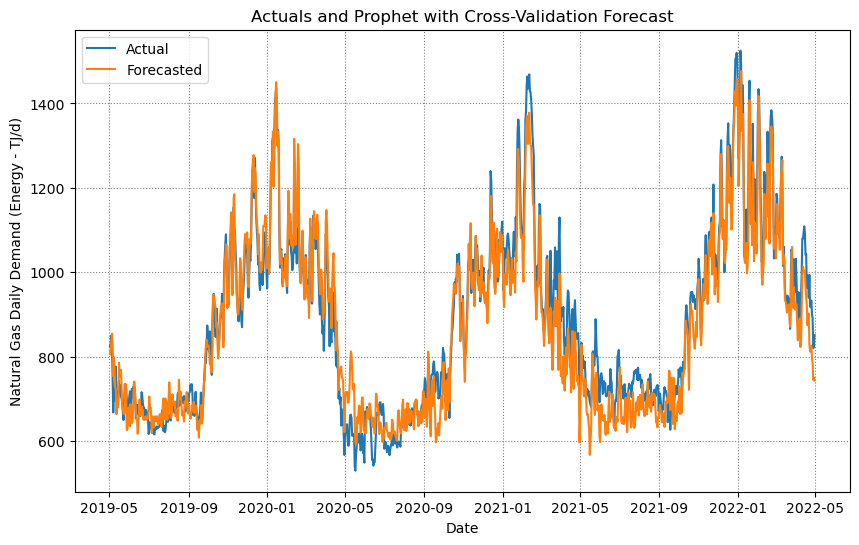


Average Metrics across all Folds:
Validation Mean Absolute Error: 46.21
Validation Mean Squared Error: 3332.07
Validation Root Mean Squared Error: 57.72
Validation R-squared: 0.93
Validation Mean Absolute Percentage Error: 5.45%
Validation Median Absolute Percentage Error: 4.37%


In [7]:
import pickle

# Prepare the training dataset for Prophet by renaming columns to 'ds' (Date) and 'y' (value)
train_val_df2 = learning_data_df.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})

# Defining a wrapper class for the Prophet model
class ProphetWrapper(BaseEstimator, RegressorMixin):
    # Initializing the class with default parameters
    def __init__(self, interval_width=0.9, yearly_seasonality=True, seasonality_mode='multiplicative'):
        self.interval_width = interval_width
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.model = None

    # Defining the fit method to train the model
    def fit(self, X, y=None):
        # Creating a Prophet model with the given parameters
        self.model = Prophet(interval_width=self.interval_width, yearly_seasonality=self.yearly_seasonality, seasonality_mode=self.seasonality_mode)
        
        # Adding additional regressors to the model
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        # Fitting the model to the data
        self.model.fit(X)

        return self

    # Defining the predict method to generate predictions
    def predict(self, X):
        return self.model.predict(X)

# Define the initial training size, the period, and the horizon
initial, period, horizon = 1644, 365, 365

# Split the data into a training/validation set and a test set
#train_val_df, test_df = train_df.copy(), validation_df.copy()

# Instantiate and fit the model
model = ProphetWrapper()
model.fit(train_val_df2)

# Pickle the model
with open('../models/prophet_cv_multivariate_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Perform cross-validation on the training/validation set
df_cv2 = cross_validation(model.model, initial=f'{initial} days', period=f'{period} days', horizon=f'{horizon} days')

# Calculate performance metrics for the cross-validation
df_metrics = performance_metrics(df_cv2)
print(df_metrics)

# Calculate MAE, MSE, RMSE, and R-squared
mae_cv2 = mean_absolute_error(df_cv2['y'], df_cv2['yhat'])
mse_cv2 = mean_squared_error(df_cv2['y'], df_cv2['yhat'])
rmse_cv2 = np.sqrt(mse_cv2)
r2_cv2 = r2_score(df_cv2['y'], df_cv2['yhat'])
mape_cv2 = np.mean(np.abs((df_cv2['y'] - df_cv2['yhat']) / df_cv2['y'])) * 100
mdape_cv2 = np.median(np.abs((df_cv2['y'] - df_cv2['yhat']) / df_cv2['y'])) * 100

# Plotting actuals and forecasted values for the cross-validation
plt.figure(figsize=(10, 6))
plt.plot(df_cv2['ds'], df_cv2['y'], label='Actual')
plt.plot(df_cv2['ds'], df_cv2['yhat'], label='Forecasted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Natural Gas Daily Demand (Energy - TJ/d)')
plt.grid(linestyle=":", color='grey')
plt.title('Actuals and Prophet with Cross-Validation Forecast')
plt.show()

# Print the performance metrics of the model
print("\nAverage Metrics across all Folds:")
print(f'Validation Mean Absolute Error: {mae_cv2:.2f}')
print(f'Validation Mean Squared Error: {mse_cv2:.2f}')
print(f'Validation Root Mean Squared Error: {rmse_cv2:.2f}')
print(f'Validation R-squared: {r2_cv2:.2f}')
print(f'Validation Mean Absolute Percentage Error: {mape_cv2:.2f}%')
print(f'Validation Median Absolute Percentage Error: {mdape_cv2:.2f}%')



Prediction Performance Metrics for the Testing Dataset:
Test Mean Absolute Error: 50.52
Test Mean Squared Error: 3803.03
Test Root Mean Squared Error: 61.67
Test R-squared: 0.91
Test Mean Absolute Percentage Error: nan%
Test Median Absolute Percentage Error: nan%


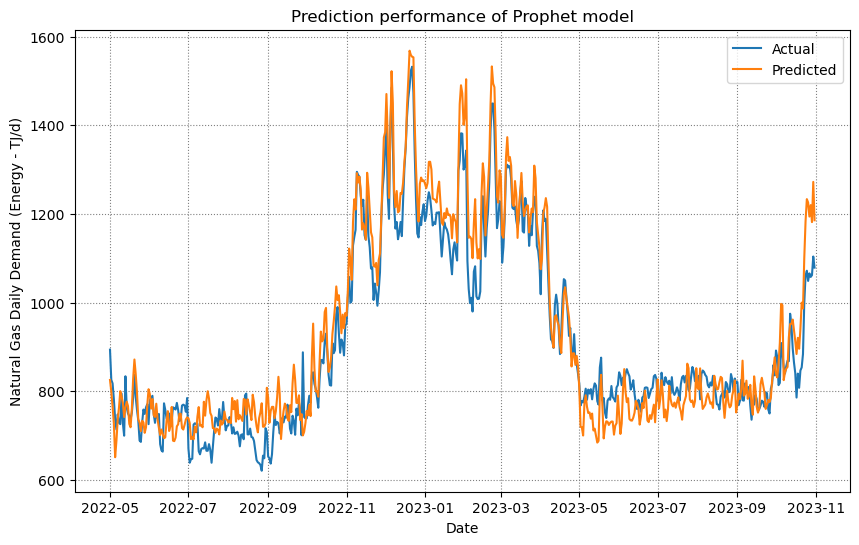

In [25]:
data = testing_data_df.copy()

# Load the previously saved model
#loaded_model = load(r"C:\Users\davin\OneDrive\Desktop\optimized_prophet_model.joblib")

# Check if the model is loaded correctly
#if loaded_model is not None:
# Prepare the test set
testing_set_df = data.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})

# Predict on the test set
y_pred = model_load.predict(testing_set_df)

# Select only the 'yhat' column
y_pred = y_pred['yhat']

# Calculate performance metrics for the test set
mae_test_hy = mean_absolute_error(testing_set_df['y'], y_pred)
mse_test_hy = mean_squared_error(testing_set_df['y'], y_pred)
rmse_test_hy = np.sqrt(mse_test_hy)
r2_test_hy = r2_score(testing_set_df['y'], y_pred)
mape_test_hy = np.mean(np.abs((testing_set_df['y'] - y_pred) / testing_set_df['y'])) * 100
mdape_test_hy = np.median(np.abs((testing_set_df['y'] - y_pred) / testing_set_df['y'])) * 100

# Print prediction performance metrics
print("\nPrediction Performance Metrics for the Testing Dataset:")
print(f'Test Mean Absolute Error: {mae_test_hy:.2f}')
print(f'Test Mean Squared Error: {mse_test_hy:.2f}')
print(f'Test Root Mean Squared Error: {rmse_test_hy:.2f}')
print(f'Test R-squared: {r2_test_hy:.2f}')
print(f'Test Mean Absolute Percentage Error: {mape_test_hy:.2f}%')
print(f'Test Median Absolute Percentage Error: {mdape_test_hy:.2f}%')

# Convert the Date to datetime
testing_set_df['ds'] = pd.to_datetime(testing_set_df['ds'])

# Plotting actuals and forecasted values for the test set
plt.figure(figsize=(10, 6))
plt.plot(testing_set_df['ds'], testing_set_df['y'], label='Actual')
plt.plot(testing_set_df['ds'], y_pred, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Natural Gas Daily Demand (Energy - TJ/d)')
plt.grid(linestyle=":", color='grey')
plt.title('Prediction performance of Prophet model')
plt.show()

## 3. Hyperparameter Tuning (Optimized Prophet model)
The Prophet model has some input parameters that one might consider tuning. Here are some general recommendations for hyperparameter tuning that may be a good starting place. 

- yearly_seasonality
- seasonality_prior_scale
- seasonality_mode
- holidays_prior_scale
- change_prior_scale

Therefore we introduced these parameters to optimized the prophet models with cross-validation

14:51:40 - cmdstanpy - INFO - Chain [1] start processing
14:51:43 - cmdstanpy - INFO - Chain [1] done processing


Best Parameters: {'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive', 'seasonality_prior_scale': 0.01, 'yearly_seasonality': True}


  0%|          | 0/3 [00:00<?, ?it/s]

14:51:44 - cmdstanpy - INFO - Chain [1] start processing
14:51:45 - cmdstanpy - INFO - Chain [1] done processing
14:51:46 - cmdstanpy - INFO - Chain [1] start processing
14:51:48 - cmdstanpy - INFO - Chain [1] done processing
14:51:50 - cmdstanpy - INFO - Chain [1] start processing
14:51:52 - cmdstanpy - INFO - Chain [1] done processing


     horizon          mse       rmse        mae      mape     mdape     smape  \
0    37 days  4191.506931  64.741848  54.190607  0.080141  0.073580  0.078891   
1    38 days  4175.894811  64.621164  53.875875  0.079572  0.073580  0.078423   
2    39 days  4160.108545  64.498903  53.681474  0.079217  0.073580  0.078176   
3    40 days  4160.901768  64.505052  53.592465  0.079012  0.073315  0.078095   
4    41 days  4078.655772  63.864354  52.903317  0.078035  0.072873  0.077226   
..       ...          ...        ...        ...       ...       ...       ...   
324 361 days  6855.269789  82.796557  73.651564  0.080652  0.081824  0.082956   
325 362 days  7006.062152  83.702223  74.871665  0.082589  0.088041  0.084882   
326 363 days  7099.976353  84.261357  75.668430  0.084032  0.088041  0.086357   
327 364 days  7166.300720  84.654006  76.490972  0.085563  0.089634  0.087882   
328 365 days  7201.336691  84.860690  77.136388  0.087206  0.092067  0.089553   

     coverage  
0    0.5198

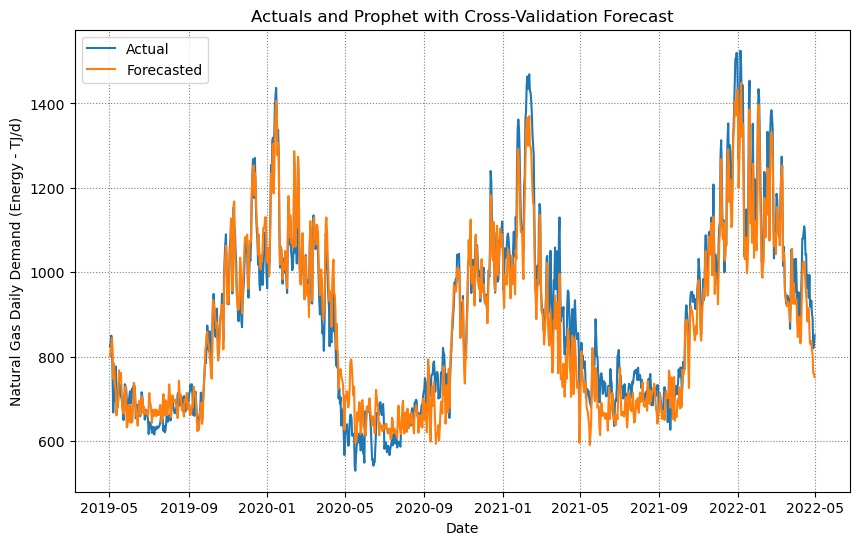


Average Metrics across all Folds:
Mean Absolute Error: 44.57
Mean Squared Error: 3116.68
Root Mean Squared Error: 55.83
R-squared: 0.93
Mean Absolute Percentage Error: 5.24%
Median Absolute Percentage Error: 4.28%


In [27]:
# Prepare the training dataset for Prophet by renaming columns to 'ds' (Date) and 'y' (value)
train_val_df3 = learning_data_df.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})

# Define a wrapper class for the Prophet model
class ProphetWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, yearly_seasonality=True, seasonality_mode='additive', seasonality_prior_scale=10.0, holidays_prior_scale=10.0):
        self.yearly_seasonality = yearly_seasonality
        self.seasonality_mode = seasonality_mode
        self.seasonality_prior_scale = seasonality_prior_scale
        self.holidays_prior_scale = holidays_prior_scale
        self.model = None

    def fit(self, X, y=None):
        self.model = Prophet(
            yearly_seasonality=self.yearly_seasonality,
            seasonality_mode=self.seasonality_mode,
            seasonality_prior_scale=self.seasonality_prior_scale,
            holidays_prior_scale=self.holidays_prior_scale
        )
        
        # Add additional regressors to the model
        for regressor in ['LOWEST_REL_HUMIDITY', 'HIGHEST_REL_HUMIDITY', 'HEATING_DEGREE_DAYS', 'COOLING_DEGREE_DAYS', 'TOTAL_PRECIPITATION', 
                          'LOWEST_TEMPERATURE', 'AVG_TEMPERATURE', 'HIGHEST_TEMPERATURE', 'DIRECTION_MAX_GUST', 'SPEED_MAX_GUST']:
            self.model.add_regressor(regressor)

        # Fit the model to the data
        self.model.fit(X)

        return self

    # Define the predict method to generate predictions
    def predict(self, X):
        return self.model.predict(X)

# Define the initial training size, the period, and the horizon
initial, period, horizon = 1644, 365, 365

# Define parameter grid for hyperparameter tuning
param_grid = {'yearly_seasonality': [True, False], 
              'seasonality_mode': ['additive', 'multiplicative'], 
              'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0], 
              'holidays_prior_scale': [0.01, 0.1, 1.0, 10.0]}

# Instantiate the model
model = ProphetWrapper()

# Perform grid search to find the best model
grid_search = GridSearchCV(model, param_grid, cv=4, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(train_val_df3)

# Print the best parameters
print(f'Best Parameters: {grid_search.best_params_}')

# Perform cross-validation on the training/validation set
df_cv_hy = cross_validation(grid_search.best_estimator_.model, initial=f'{initial} days', period=f'{period} days', horizon=f'{horizon} days')

# Calculate performance metrics for the cross-validation
df_metrics = performance_metrics(df_cv_hy)
print(df_metrics)

# Calculate MAE, MSE, RMSE, and R-squared
mae_cv_hy = mean_absolute_error(df_cv_hy['y'], df_cv_hy['yhat'])
mse_cv_hy = mean_squared_error(df_cv_hy['y'], df_cv_hy['yhat'])
rmse_cv_hy = np.sqrt(mse_cv_hy)
r2_cv_hy = r2_score(df_cv_hy['y'], df_cv_hy['yhat'])
mape_cv_hy = np.mean(np.abs((df_cv_hy['y'] - df_cv_hy['yhat']) / df_cv_hy['y'])) * 100
mdape_cv_hy = np.median(np.abs((df_cv_hy['y'] - df_cv_hy['yhat']) / df_cv_hy['y'])) * 100

# Plot actuals and forecasted values for the cross-validation
plt.figure(figsize=(10, 6))
plt.plot(df_cv_hy['ds'], df_cv_hy['y'], label='Actual')
plt.plot(df_cv_hy['ds'], df_cv_hy['yhat'], label='Forecasted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Natural Gas Daily Demand (Energy - TJ/d)')
plt.grid(linestyle=":", color='grey')
plt.title('Actuals and Prophet with Cross-Validation Forecast')
plt.show()

# Print the performance metric of the Optimized model
print("\nAverage Metrics across all Folds:")
print(f'Mean Absolute Error: {mae_cv_hy:.2f}')
print(f'Mean Squared Error: {mse_cv_hy:.2f}')
print(f'Root Mean Squared Error: {rmse_cv_hy:.2f}')
print(f'R-squared: {r2_cv_hy:.2f}')
print(f'Mean Absolute Percentage Error: {mape_cv_hy:.2f}%')
print(f'Median Absolute Percentage Error: {mdape_cv_hy:.2f}%')

## 4. Prophet Model Validation Perfomance
Here is a comparison summary of the prophet model performance metrics for the evaluation of the Saskatchewan Natural Gas consumption time series dataset.

In [11]:
# Define the metrics for the model
metrics_base_model = [mse_bm, rmse_bm, mape_bm, mae_bm, mdape_bm, r2_bm]
metrics_validate_uni = [mse_cv, rmse_cv, mape_cv, mae_cv, mdape_cv, r2_cv]
metrics_validate_cv = [mse_cv2, rmse_cv2, mape_cv2, mae_cv2, mdape_cv2, r2_cv2]
metrics_validate_hy = [mse_cv_hy, rmse_cv_hy, mape_cv_hy, mae_cv_hy, mdape_cv_hy, r2_cv_hy]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_prophet_metrics = pd.DataFrame({'Baseline model': metrics_base_model, 'Prophet Univariate model': metrics_validate_uni, 
                                   'Prophet model_Cross-validation': metrics_validate_cv, 'Optimized Prophet model': metrics_validate_hy}, index=labels)

# Transpose the DataFrame
df_prophet_metrics = df_prophet_metrics.transpose()

# Save DataFrame to a CSV file
df_prophet_metrics.to_csv('../data/df_prophet_metrics.csv', index=False)

df_prophet_metrics.head(10)

,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
Baseline model,6656.062839,81.584697,7.334084,70.175339,7.051938,0.854337
Prophet Univariate model,13639.386943,116.787786,9.382524,87.798045,7.863762,0.703238
Prophet model_Cross-validation,3332.070447,57.724089,5.448179,46.214878,4.373319,0.927502
Optimized Prophet model,3116.676144,55.827199,5.237576,44.571783,4.280689,0.932188


- The results indicate that the Optimized Prophet model outperforms the Baseline model, standard Train-test Split, and Cross-validation methods in terms of various metrics. The Mean Squared Error (MSE) for the Optimized Prophet model is 4373.95, which is significantly lower than the Train-test Split (10725.22) and Cross-Validation (5597.74) methods. 
- Similarly, the Root Mean Squared Error (RMSE), Mean Absolute Percentage Error (MAPE), Mean Absolute Error (MAE), and Median Absolute Percentage Error (MDAPE) are all lower for the Optimized Prophet model compared to the other three methods. Furthermore, the R-squared value for the Optimized Prophet model is 0.91, which is higher than the Train-test Split method (0.78) and the Cross-Validation method (0.88), indicating a better fit performs the best among the four models on this time series dataset.
- The lower the error metrics (MSE, RMSE, MAPE, MAE, MDAPE) and the closer the R-squared value is to 1, the better the model’s performance.


## 5. Prediction Performance of Prophet

Prediction Performance Metrics for the Testing Dataset:
Test Mean Absolute Error: 53.101
Test Mean Squared Error: 4337.651
Test Root Mean Squared Error: 65.861
Test R-squared: 0.897
Test Mean Absolute Percentage Error: nan%
Test Median Absolute Percentage Error: nan%


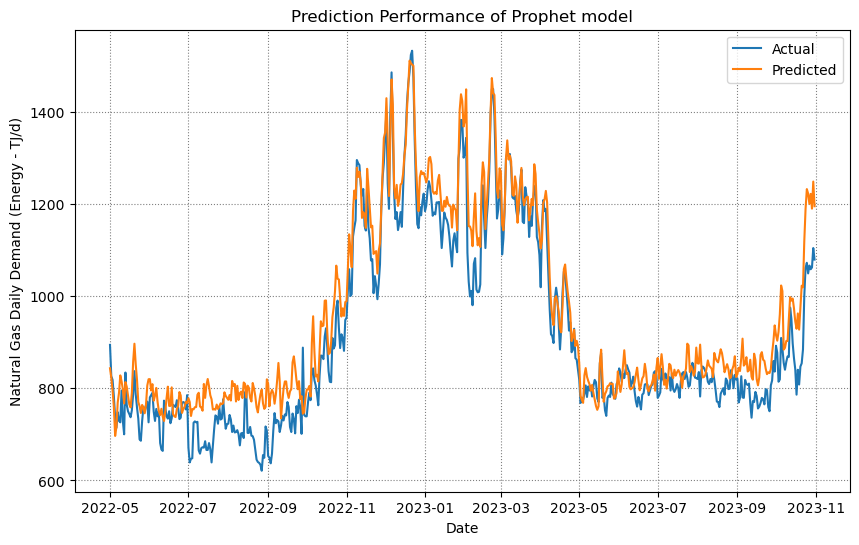

In [61]:
# Load the saved Prophet model
with open('../models/best_prophet_model.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

# Load the testing dataset
data = testing_data_df.copy()
testing_set_df = data.rename(columns={'DATE': 'ds', 'NG_DEMAND': 'y'})

# Make predictions on the test set
predictions = loaded_model.predict(testing_set_df)
predictions_df = pd.DataFrame(predictions)

# Extract 'yhat' predictions
y_pred = predictions_df['yhat']

# Create a dataframe to store results
prophet_results_df = testing_set_df[['ds', 'y']].copy()
# Reset the index of prophet_results_df
prophet_results_df.reset_index(drop=True, inplace=True)
# Copy 'yhat' from predictions_df to 'yhat' in prophet_results_df
prophet_results_df['yhat'] = predictions_df['yhat'].copy()


# Calculate performance metrics
mae_test = mean_absolute_error(testing_set_df['y'], y_pred)
mse_test = mean_squared_error(testing_set_df['y'], y_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(testing_set_df['y'], y_pred)
mape_test = np.mean(np.abs((testing_set_df['y'] - y_pred) / testing_set_df['y'])) * 100
mdape_test = np.median(np.abs((testing_set_df['y'] - y_pred / testing_set_df['y'])) * 100)

# Print prediction performance metrics
print("Prediction Performance Metrics for the Testing Dataset:")
print(f'Test Mean Absolute Error: {mae_test:.3f}')
print(f'Test Mean Squared Error: {mse_test:.3f}')
print(f'Test Root Mean Squared Error: {rmse_test:.3f}')
print(f'Test R-squared: {r2_test:.3f}')
print(f'Test Mean Absolute Percentage Error: {mape_test:.3f}%')
print(f'Test Median Absolute Percentage Error: {mdape_test:.3f}%')

# Convert the 'ds' column to datetime
prophet_results_df['ds'] = pd.to_datetime(prophet_results_df['ds'])

# Plotting actual vs. forecasted values for the test set
plt.figure(figsize=(10, 6))
plt.plot(prophet_results_df['ds'], prophet_results_df['y'], label='Actual')
plt.plot(prophet_results_df['ds'], y_pred, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Natural Gas Daily Demand (Energy - TJ/d)')
plt.grid(linestyle=":", color='grey')
plt.title('Prediction Performance of Prophet model')
plt.show()

In [62]:
# Save the prediction result dataframe
prophet_results_df.to_csv('../data/prophet_prediction.csv', index=False)
print(prophet_results_df)

            ds     y         yhat
0   2022-05-01   894   843.235901
1   2022-05-02   826   822.467927
2   2022-05-03   818   795.454454
3   2022-05-04   782   759.290193
4   2022-05-05   737   696.449118
..         ...   ...          ...
544 2023-10-27  1066  1199.852283
545 2023-10-28  1058  1221.488383
546 2023-10-29  1062  1189.455045
547 2023-10-30  1104  1248.153253
548 2023-10-31  1079  1194.691063

[549 rows x 3 columns]


In [16]:
# Define the metrics for the predicted model
prophet_prediction_metrics = [mse_test_hy, rmse_test_hy, mape_test_hy, mae_test_hy, mdape_test_hy, r2_test_hy]

# Define the labels for the metrics
labels = ['MSE', 'RMSE', 'MAPE', 'MAE', 'MDAPE', 'R-squared']

# Create a DataFrame to store the metrics
df_prophet_pred = pd.DataFrame({'Prophet Model Prediction': prophet_prediction_metrics}, index=labels)

# Transpose the DataFrame
df_prophet_pred = df_prophet_pred.transpose()

# Save the DataFrame to a CSV file
df_prophet_pred.to_csv('../data/prophet_predictions_metrics.csv', index=False)
df_prophet_pred.head()

,MSE,RMSE,MAPE,MAE,MDAPE,R-squared
Prophet Model Prediction,4337.651102,65.860847,NaN,53.100838,NaN,0.896919


# Conclusion
- The Prophet univariate model with the Train-test split method underperformed compared to the baseline model (Linear Regression), however the multivariate Prophet model outperform the baseline model.
- In addition, we utilized some of Prophet’s evaluation tools, such as cross-validation and hyperparameter tuning, to optimize our model’s performance. These tools are instrumental in refining the model and improving its predictive accuracy.
- B
By fine-tuning the hyperparameters, we were able to enhance our results furth and identified the Optimized Prophet model as the best model for this taskecy. 